In [1]:
from fit.datamodules.tomo_rec import MNISTTomoFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate
from fit.utils.tomo_utils import get_proj_coords, get_img_coords

from matplotlib import pyplot as plt

import torch

import numpy as np

# MNIST Tomo Fourier Target
Create a MNIST projection dataset with 15 angles and batch-size 4.

In [2]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/home/tibuch/Data/mnist/', batch_size=4, num_angles=15)
dm.setup()

In [3]:
train_dl = dm.train_dataloader()

In [4]:
# x and y are normalized magnitude and angle of the Fourier coefficients
for x, y, y_real, (mag_min, mag_max) in train_dl:
    break

In [5]:
print(x.shape, y.shape, y_real.shape)

torch.Size([4, 315, 2]) torch.Size([4, 420, 2]) torch.Size([4, 28, 28])


In [6]:
# We have to convert angle and magnitude back to Fourier coefficients
x_fc = convert2FC(x, mag_min, mag_max)
y_fc = convert2FC(y, mag_min, mag_max)

In [7]:
# Computing the projection and target Fourier coefficient coordinates
srcx, srcy = get_proj_coords(angles=dm.gt_ds.get_ray_trafo().geometry.angles, img_shape=28)
dstx, dsty = get_img_coords(img_shape=28, endpoint=False)

In [8]:
# Interpolate target Fourier coefficients based on projection Fourier coefficients --> Fourier Slice Theorem
i = 0
x_dft = fft_interpolate(srcx, srcy, dstx, dsty, x_fc[i], target_shape=(28, 15))

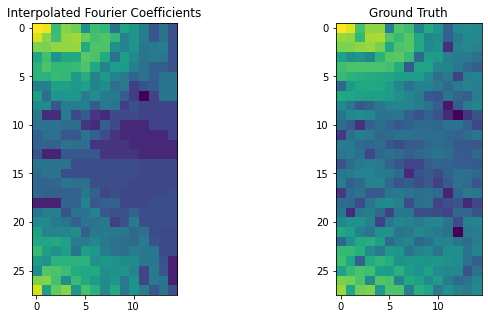

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(x_dft)))
plt.title('Interpolated Fourier Coefficients');
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(y_fc[i].reshape(28, 15))))
plt.title('Ground Truth');

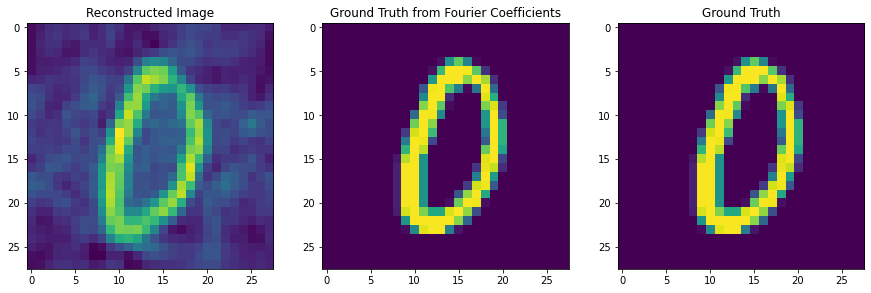

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.roll(np.fft.irfftn(x_dft), (14, 14), (0, 1)))
plt.title('Reconstructed Image');
plt.subplot(1,3,2)
plt.imshow(np.roll(np.fft.irfftn(y_fc[i].reshape(28, 15)), (14, 14), (0, 1)))
plt.title('Ground Truth from Fourier Coefficients');
plt.subplot(1,3,3)
plt.imshow(y_real[i])
plt.title('Ground Truth');

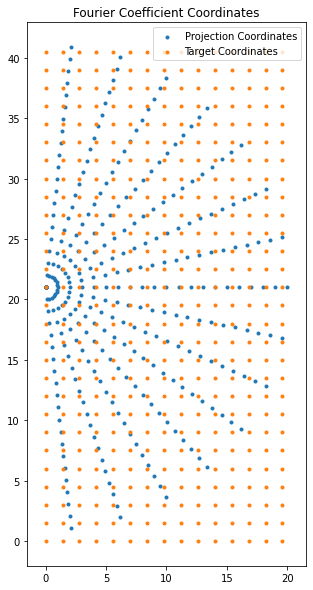

In [11]:
plt.figure(figsize=(5,10))
plt.scatter(srcx, srcy, marker='.', label='Projection Coordinates')
plt.scatter(dstx, dsty, marker='.', label='Target Coordinates')
plt.axis('equal')
plt.legend();
plt.title('Fourier Coefficient Coordinates');